In [1]:
pip install lazypredict

In [2]:
import pandas as pd
from tabulate import tabulate
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
import lazypredict
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from lightgbm import LGBMClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

In [ ]:
# Read the dataset
from google.colab import files
import io

uploaded = files.upload()
churnData = pd.read_csv(io.BytesIO(uploaded['Churn_data.csv']))

**This report focuses on predicting churn in a given dataset. Churn refers to customers discontinuing a product or service.**

In [5]:
print(tabulate(churnData.head(), headers='keys', tablefmt='fancy_grid'))


╒════╤══════════════╤══════════════╤══════════╤════════════╤═══════════════╤═══════════════════╤════════════════╤══════════════╤════════════════════╤════════════════════╤═════════════════════╤════════════╕
│    │   CustomerID │ Geography    │ Gender   │ Age_Band   │   TenureYears │   EstimatedIncome │   BalanceEuros │   NoProducts │   CreditCardholder │   CustomerWithLoan │   Digital_TRX_ratio │   Inactive │
╞════╪══════════════╪══════════════╪══════════╪════════════╪═══════════════╪═══════════════════╪════════════════╪══════════════╪════════════════════╪════════════════════╪═════════════════════╪════════════╡
│  0 │      5188208 │ Rest_GR      │ Male     │ 18-25      │             0 │          40684    │        50086.2 │            1 │                  0 │                  0 │                0.38 │          0 │
├────┼──────────────┼──────────────┼──────────┼────────────┼───────────────┼───────────────────┼────────────────┼──────────────┼────────────────────┼────────────────────┼──────

In [ ]:
print(churnData.info())

Some variables should be categorical. Convert these variables.

In [ ]:
# Convert variables to categorical
catColumns = ['CustomerID','Geography', 'Gender', 'Age_Band']
churnData[catColumns] = churnData[catColumns].astype('category')

# Convert variables to boolean data type
# booleanColumns = ['CreditCardholder', 'CustomerWithLoan', 'Inactive']
# churnData[booleanColumns] = churnData[booleanColumns].astype(bool)

We should check some summary statistics. We observe that Balance has different mean and median, therefore we know that this variable is skewed.

In [ ]:
churnData.describe()

,TenureYears,EstimatedIncome,BalanceEuros,NoProducts,CreditCardholder,CustomerWithLoan,Digital_TRX_ratio,Inactive
count,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00
mean,5.01,88078.51,50480.69,1.53,0.71,0.52,0.70,0.20
std,2.89,50034.13,41182.29,0.58,0.46,0.50,0.20,0.40
min,0.00,1010.07,0.00,1.00,0.00,0.00,0.00,0.00
25%,3.00,45371.83,0.00,1.00,0.00,0.00,0.56,0.00
50%,5.00,88168.71,64151.04,1.00,1.00,1.00,0.70,0.00
75%,7.00,130967.77,84245.20,2.00,1.00,1.00,0.83,0.00
max,10.00,174993.46,165592.74,4.00,1.00,1.00,1.42,1.00


# Exploratory Analysis

We examined the dataset for any missing values (NAs). Fortunately, our analysis revealed that there were no missing values present in the dataset.

In [ ]:
# Check for missing values in each column
missingValues = churnData.isna().sum() + churnData.isnull().sum()

# Display the missing values count for each column
print(missingValues)

CustomerID           0
Geography            0
Gender               0
Age_Band             0
TenureYears          0
EstimatedIncome      0
BalanceEuros         0
NoProducts           0
CreditCardholder     0
CustomerWithLoan     0
Digital_TRX_ratio    0
Inactive             0
dtype: int64


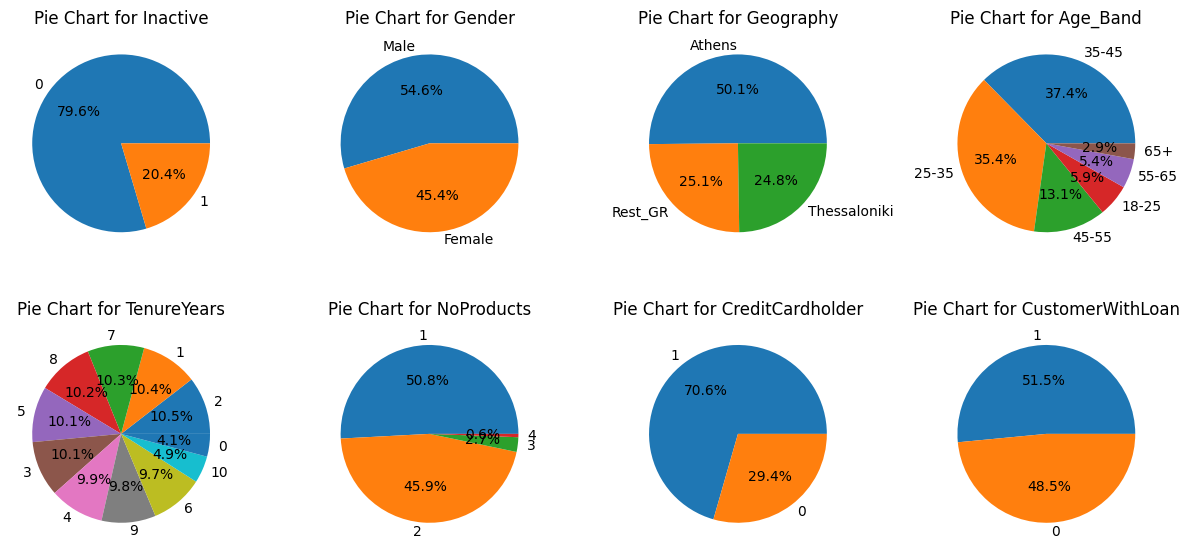

In [9]:
# Define the available columns for selection
availableCols = ['Inactive', 'Gender', 'Geography', 'Age_Band', 'TenureYears', 'NoProducts', 'CreditCardholder', 'CustomerWithLoan']

# Create a figure with 4 rows and 2 columns
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

# Flatten the axes array
axes = axes.flatten()

# Iterate over the available columns and plot pie charts
for i, col in enumerate(availableCols):
    # Group the data by the selected column and calculate the count
    columnN = churnData[col].value_counts()

    # Create a pie chart for the current column
    axes[i].pie(columnN.values, labels=columnN.index, autopct='%1.1f%%')
    axes[i].set_title(f"Pie Chart for {col}")

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

    • Churn: Approximately 1 in 5 customers experienced churn within the last 3 months.
    • Gender: Males constitute around 10% more of the customer base compared to females.
    • Geography: Half of the customers have registered in the region of Athens.
    • Age Band: Nearly 2 in 3 customers fall within the age range of 25-45 years.
    • NoProducts: Approximately 96% of the customers have 1 or 2 products.
    • CreditCardholder: 7 out of 10 customers hold a credit card.
    • CustomerWithLoan: Half of the customers have taken a loan.

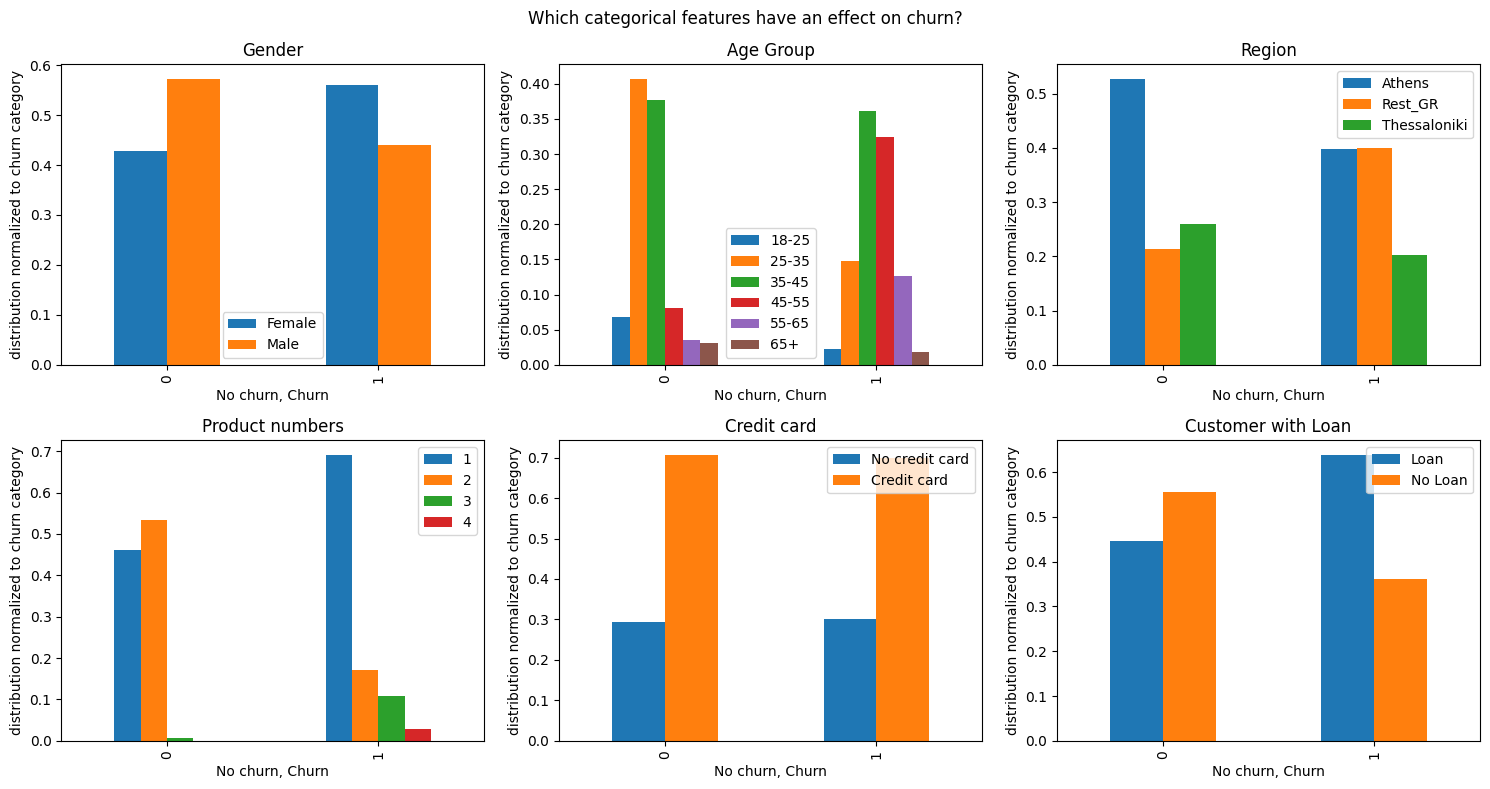

In [15]:
fig,ax = plt.subplots(nrows=2, ncols=3, figsize=[15,8])


pd.crosstab(index=churnData.Inactive, columns=churnData.Gender, normalize='index').plot(kind='bar', legend=True, ax=ax[0,0], ylabel='distribution normalized to churn category', xlabel= 'No churn, Churn', title='Gender');
ax[0,0].legend(loc='best')
pd.crosstab(index=churnData.Inactive, columns=churnData.Age_Band, normalize='index').plot(kind='bar', legend=True, ax=ax[0,1], ylabel='distribution normalized to churn category', xlabel= 'No churn, Churn', title='Age Group');
ax[0,1].legend(loc='best')
pd.crosstab(index=churnData.Inactive, columns=churnData.Geography, normalize='index').plot(kind='bar', legend=True, ax=ax[0,2], ylabel='distribution normalized to churn category', xlabel= 'No churn, Churn', title='Region');
ax[0,2].legend(loc='best')
pd.crosstab(index=churnData.Inactive, columns=churnData.NoProducts, normalize='index').plot(kind='bar', legend=True, ax=ax[1,0], ylabel='distribution normalized to churn category', xlabel= 'No churn, Churn', title='Product numbers');
ax[1,0].legend(loc='best')
pd.crosstab(index=churnData.Inactive, columns=churnData.CreditCardholder, normalize='index').plot(kind='bar', legend=True, ax=ax[1,1], ylabel='distribution normalized to churn category', xlabel= 'No churn, Churn', title='Credit card');
ax[1,1].legend(labels=['No credit card','Credit card'], loc='best')
pd.crosstab(index=churnData.Inactive, columns=churnData.CustomerWithLoan, normalize='index').plot(kind='bar', legend=True, ax=ax[1,2], ylabel='distribution normalized to churn category', xlabel= 'No churn, Churn', title='Customer with Loan');
ax[1,2].legend(labels=['Loan','No Loan'],loc='best')

fig.suptitle('Which categorical features have an effect on churn?')
plt.tight_layout()

    • Gender: When the gender is female, there is a higher likelihood of churn compared to males.
    • Age Group: Customers belonging to the age groups of 25-35 and 35-45 are more likely to churn.
    • Geography: Customers who registered in the "Rest of Greece" region have a higher probability of churn.
    • NoProducts: Customers with only one product are more likely to churn compared to those with multiple products.

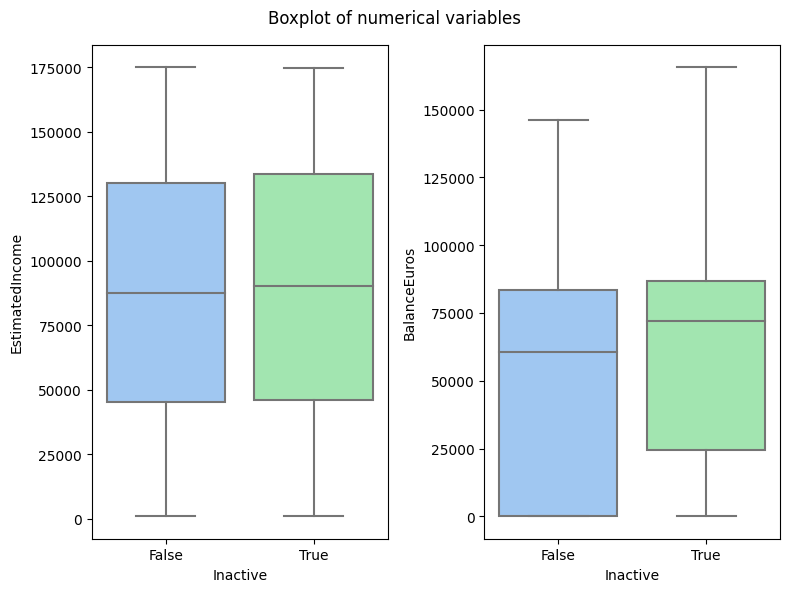

In [ ]:
fig,ax = plt.subplots(nrows= 1, ncols=2, figsize=[8,6])

sns.boxplot(data=churnData, x='Inactive', y='EstimatedIncome',ax=ax[0])
sns.boxplot(data=churnData, x='Inactive', y='BalanceEuros',ax=ax[1])

fig.suptitle('Boxplot of numerical variables')
plt.tight_layout()

As the balance in euros increases, the likelihood of a customer churning also increases.

<Axes: >

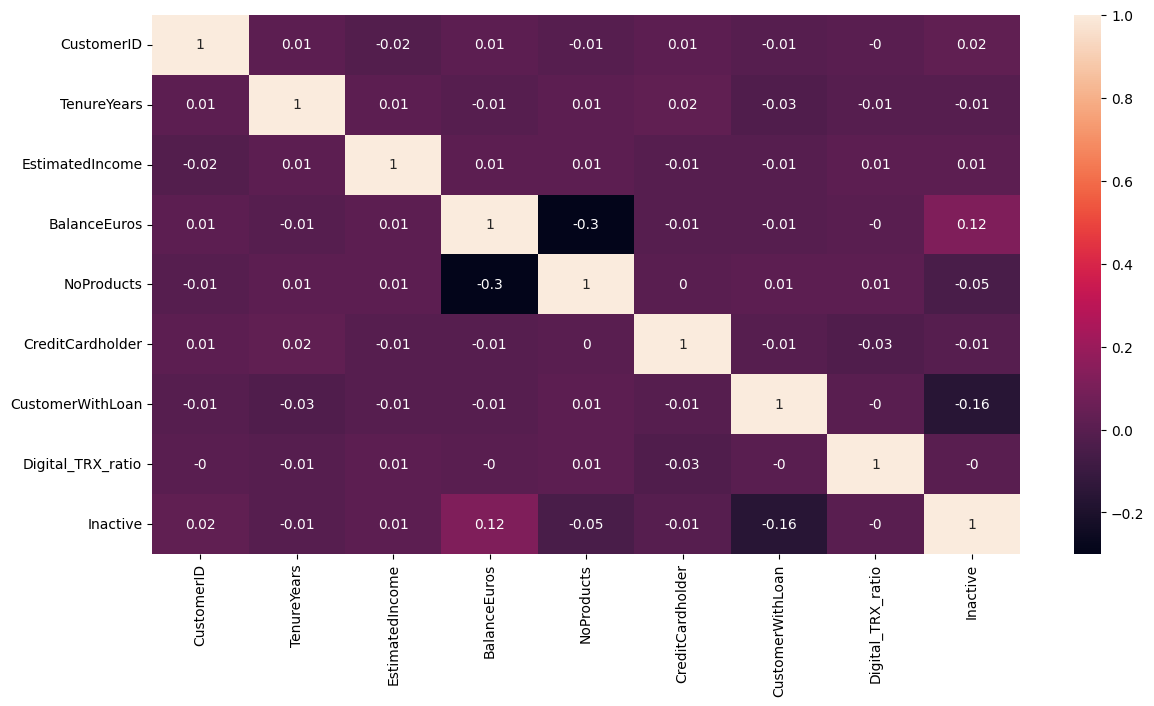

In [16]:
correlation = churnData.corr().round(2)
plt.figure(figsize = (14,7))
sns.heatmap(correlation, annot = True)

We observed a positive correlation between churn and balance in euros, indicating that as the balance increases, the likelihood of churn also increases. However, we did not observe significant correlations among the other independent variables.

# Data preparation

Detect outliers number as the outliers can affect the model's performance.To detect outliers, we employed the interquartile range (IQR) method.

In [17]:
#function for identifying outliers
def count_outliers(data):
    # Select numeric columns
    numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns

    # Initialize a dictionary to store the outlier counts
    outlier_counts = {}

    # Calculate and store the outlier counts for each numeric column
    for column in numeric_columns:
        # Calculate the IQR
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1

        # Define the outlier boundaries
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Count the outliers
        num_outliers = len(data[(data[column] < lower_bound) | (data[column] > upper_bound)])

        # Store the outlier count for the column
        outlier_counts[column] = num_outliers

    return outlier_counts


In [18]:
# Count outliers in all numeric columns
outlier_counts = count_outliers(churnData)

# Print the outlier counts
for column, count in outlier_counts.items():
    print(f"Column '{column}' has {count} outliers.")

Column 'CustomerID' has 0 outliers.
Column 'TenureYears' has 0 outliers.
Column 'EstimatedIncome' has 0 outliers.
Column 'BalanceEuros' has 0 outliers.
Column 'NoProducts' has 60 outliers.
Column 'CreditCardholder' has 0 outliers.
Column 'CustomerWithLoan' has 0 outliers.
Column 'Digital_TRX_ratio' has 74 outliers.
Column 'Inactive' has 2042 outliers.


Convert categorical variables to dummies

In [19]:
churnData.drop('CustomerID',axis=1, inplace=True)

In [45]:
# Select the categorical columns to encode
categorical_columns = ['Geography', 'Gender', 'Age_Band']

# Perform one-hot encoding
df_encoded = pd.get_dummies(churnData, columns=categorical_columns, drop_first = True)

# Print the encoded DataFrame
print(df_encoded.head())

   TenureYears  EstimatedIncome  BalanceEuros  NoProducts  CreditCardholder  \
0            0         40683.96      50086.21           1                 0   
1            4          2429.51          0.00           1                 1   
2            4         41694.49      26852.71           1                 1   
3            5         74523.33      90325.62           1                 0   
4            9        111050.49     100537.06           2                 0   

   CustomerWithLoan  Digital_TRX_ratio  Inactive  Geography_Rest_GR  \
0                 0               0.38         0                  1   
1                 0               0.33         1                  0   
2                 1               0.72         0                  0   
3                 0               0.08         0                  1   
4                 0               1.38         0                  1   

   Geography_Thessaloniki  Gender_Male  Age_Band_25-35  Age_Band_35-45  \
0                       

Create dependent and independent variables datasets

In [48]:
# Split the dataset into X (features) and y (target variable)
X = df_encoded.drop('Inactive', axis=1)  # Features (all columns except 'Inactive')
y = df_encoded['Inactive']  # Target variable ('Inactive' column)
print(X.head())

   TenureYears  EstimatedIncome  BalanceEuros  NoProducts  CreditCardholder  \
0            0         40683.96      50086.21           1                 0   
1            4          2429.51          0.00           1                 1   
2            4         41694.49      26852.71           1                 1   
3            5         74523.33      90325.62           1                 0   
4            9        111050.49     100537.06           2                 0   

   CustomerWithLoan  Digital_TRX_ratio  Geography_Rest_GR  \
0                 0               0.38                  1   
1                 0               0.33                  0   
2                 1               0.72                  0   
3                 0               0.08                  1   
4                 0               1.38                  1   

   Geography_Thessaloniki  Gender_Male  Age_Band_25-35  Age_Band_35-45  \
0                       0            1               0               0   
1         

Scale variables and create train and test sets

In [ ]:
# Perform feature scaling on X
columns_to_scale = ['TenureYears', 'EstimatedIncome', 'BalanceEuros','NoProducts', 'Digital_TRX_ratio']
scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X[columns_to_scale])
#X_scaled = scaler.fit_transform(X)
X[columns_to_scale] = scaler.fit_transform(X[columns_to_scale])
X_scaled = X.copy()


In [50]:
print(X_scaled.head(3))

   TenureYears  EstimatedIncome  BalanceEuros  NoProducts  CreditCardholder  \
0        -1.73            -0.95         -0.01       -0.91                 0   
1        -0.35            -1.71         -1.23       -0.91                 1   
2        -0.35            -0.93         -0.57       -0.91                 1   

   CustomerWithLoan  Digital_TRX_ratio  Geography_Rest_GR  \
0                 0              -1.59                  1   
1                 0              -1.84                  0   
2                 1               0.12                  0   

   Geography_Thessaloniki  Gender_Male  Age_Band_25-35  Age_Band_35-45  \
0                       0            1               0               0   
1                       1            0               0               0   
2                       0            1               0               0   

   Age_Band_45-55  Age_Band_55-65  Age_Band_65+  
0               0               0             0  
1               0               0        

In [51]:
# Split the scaled data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Print the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (8000, 15)
y_train shape: (8000,)
X_test shape: (2000, 15)
y_test shape: (2000,)


Check all classification models to identify the best models.

In [52]:
# Model
model = LazyClassifier(verbose = 0, classifiers='all')
listofmodels, churnpredictions= model.fit(X_train, X_test, y_train, y_test)

100%|██████████| 29/29 [00:23<00:00,  1.21it/s]


In [53]:
print(listofmodels)

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LGBMClassifier                     0.85               0.71     0.71      0.83   
QuadraticDiscriminantAnalysis      0.80               0.70     0.70      0.80   
NearestCentroid                    0.73               0.70     0.70      0.75   
XGBClassifier                      0.84               0.70     0.70      0.83   
ExtraTreesClassifier               0.84               0.70     0.70      0.83   
AdaBoostClassifier                 0.84               0.70     0.70      0.83   
RandomForestClassifier             0.84               0.69     0.69      0.83   
SVC                                0.85               0.69     0.69      0.83   
GaussianNB                         0.80               0.68     0.68      0.79   
BaggingClassifier                  0.83               0.68     0.68      0.82   
KNeighborsClassifier        

We are interested mostly in F1 Score. The F1 score is a single metric that combines precision and recall to measure the overall accuracy of a classification model.

In [54]:
listofmodels.sort_values(by = 'F1 Score',inplace = True,ascending = False)
line = px.line(data_frame= listofmodels ,y =["F1 Score"] , markers = True)
line.update_xaxes(title="Model",
              rangeslider_visible = False)
line.update_yaxes(title = "F1 Score")
line.update_traces(line_color="red")
line.update_layout(showlegend = True,
    title = {
        'text': 'F1 Score Models Comparison'})

line.show()

LGBMclasifier and RandomForestClassifier are the best models (2 of the best models). We will continue with these models.

1. LGBM parameters tuning

In [55]:
# Create the LGBMClassifier model
model = LGBMClassifier()

# Define the parameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [3, 5, 7]
}

#scoring = ['precision', 'recall', 'f1']

# Create the GridSearchCV object
grid_search = GridSearchCV(model, param_grid, scoring='recall', cv=10)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Fit the LGBMClassifier with the best parameters to the entire training data
best_model = LGBMClassifier(**best_params)
best_model.fit(X_train, y_train)

# Evaluate the best model on the test data
y_pred = best_model.predict(X_test)

# Compute evaluation metrics
report = classification_report(y_test, y_pred, target_names=['Active', 'Inactive'])
confusion_mat = confusion_matrix(y_test, y_pred)

In terms of churn prediction (class 'Inactive'), the model's performance could be further improved.

In [56]:
# Print classification report
print(report)

              precision    recall  f1-score   support

      Active       0.87      0.95      0.91      1576
    Inactive       0.72      0.46      0.56       424

    accuracy                           0.85      2000
   macro avg       0.79      0.71      0.74      2000
weighted avg       0.84      0.85      0.83      2000



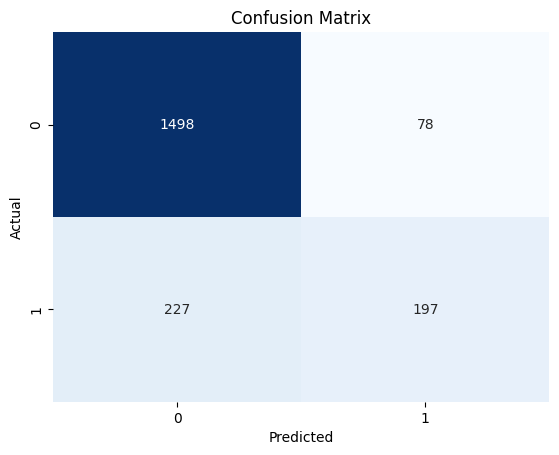

In [57]:
# Print confusion matrix
# Create a heatmap of the confusion matrix
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

The first significant feature is the Estimated Income, which represents the customers' estimated income level. Similarly, the Balance variable, reflecting the customers' account balance, holds importance. Another influential feature is the Digital TRX Ratio, which measures the ratio of digital transactions made by customers.

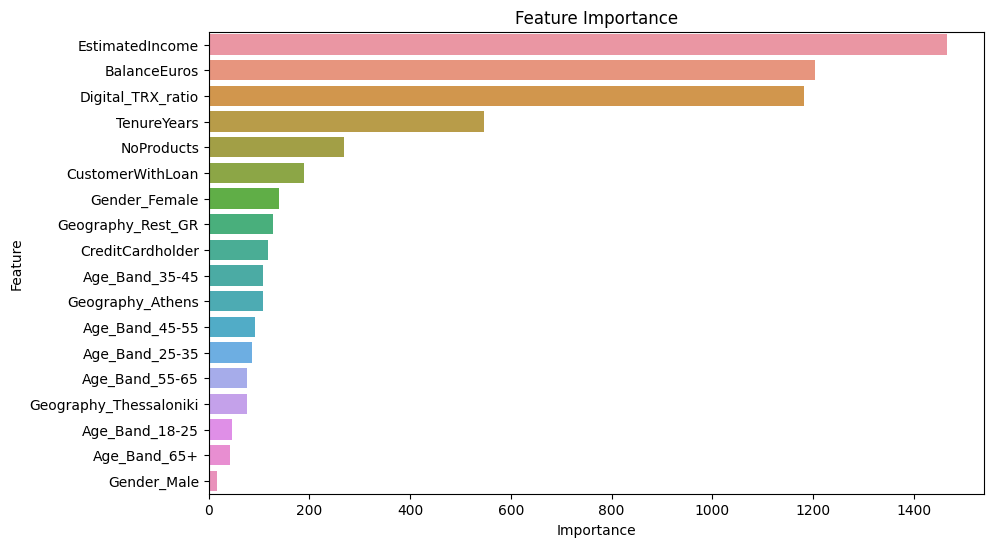

In [ ]:
importance = best_model.feature_importances_
feature_names = X.columns

# Create a DataFrame to store feature importance
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

2. Random Forest

In [58]:
# Create the RandomForestClassifier model
modelRF = RandomForestClassifier()

# Define the parameter grid for tuning
param_gridRF = {'n_estimators': [50, 100, 200],
                   'max_depth': [3, 5, 7],
                   'max_features': ['auto', 'sqrt'],
                   'min_samples_leaf': [1, 2, 4]}

# Create the GridSearchCV object
grid_searchRF = GridSearchCV(modelRF, param_gridRF, scoring='recall', cv=10)

# Fit the GridSearchCV object to the training data
grid_searchRF.fit(X_train, y_train)

# Get the best parameters and the best score
best_paramsRF = grid_searchRF.best_params_
best_scoreRF = grid_searchRF.best_score_

# Fit the RandomForestClassifier with the best parameters to the entire training data
best_modelRF = RandomForestClassifier(**best_paramsRF)
best_modelRF.fit(X_train, y_train)

# Evaluate the best model on the test data
y_predRF = best_modelRF.predict(X_test)

# Compute evaluation metrics
reportRF = classification_report(y_test, y_predRF, target_names=['Active', 'Inactive'])
confusion_matRF = confusion_matrix(y_test, y_predRF)


In [59]:
# Print the classification report and confusion matrix
print(reportRF)

              precision    recall  f1-score   support

      Active       0.86      0.97      0.91      1576
    Inactive       0.80      0.39      0.52       424

    accuracy                           0.85      2000
   macro avg       0.83      0.68      0.72      2000
weighted avg       0.84      0.85      0.83      2000



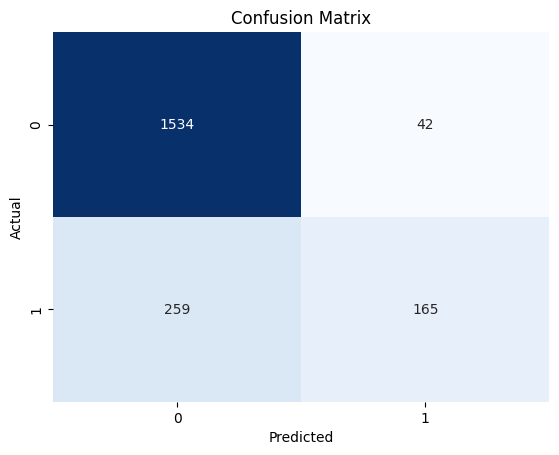

In [60]:
# Print confusion matrix
# Create a heatmap of the confusion matrix
sns.heatmap(confusion_matRF, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Random forest is not as good as the LGBM.

3. LGBM with custom threshold identify custom threshold in order to improve the Recall

In [61]:
# Predict probabilities using the best model
y_pred_proba = best_model.predict_proba(X_test)

# Specify the new threshold
new_threshold = 0.3

# Adjust the predicted labels based on the new threshold
y_pred_adjusted = (y_pred_proba[:, 1] >= new_threshold).astype(int)

# Compute evaluation metrics with the adjusted labels
report_adjusted = classification_report(y_test, y_pred_adjusted, target_names=['Active', 'Inactive'])
confusion_mat_adjusted = confusion_matrix(y_test, y_pred_adjusted)

In [62]:
print(report_adjusted)

              precision    recall  f1-score   support

      Active       0.90      0.89      0.89      1576
    Inactive       0.60      0.64      0.62       424

    accuracy                           0.83      2000
   macro avg       0.75      0.76      0.76      2000
weighted avg       0.84      0.83      0.84      2000



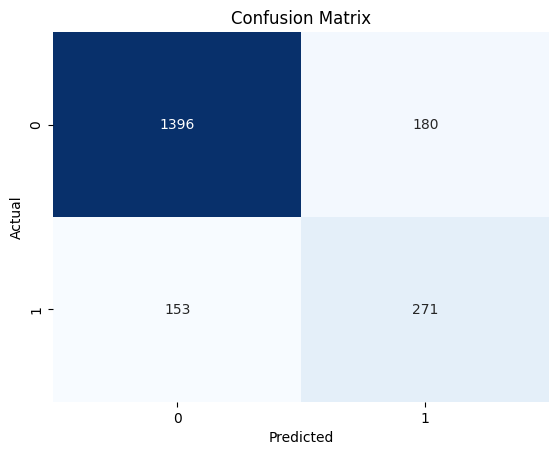

In [63]:
# Print confusion matrix
# Create a heatmap of the confusion matrix
sns.heatmap(confusion_mat_adjusted, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Threshold identification using the f-score

In [64]:
# Predict probabilities using the best model
#y_pred_proba = best_model.predict_proba(X_test)

# Initialize variables to store optimal threshold and corresponding F1 score
optimal_threshold = 0.5
best_f1_score = 0.0

# Iterate over different threshold values
for threshold in np.arange(0.1, 1.0, 0.05):
    # Adjust the predicted labels based on the current threshold
    y_pred_adjusted = (y_pred_proba[:, 1] >= threshold).astype(int)

    # Compute F1 score using the adjusted labels
    f1 = f1_score(y_test, y_pred_adjusted)

    # Check if the current threshold produces a better F1 score
    if f1 > best_f1_score:
        best_f1_score = f1
        optimal_threshold = threshold

# Print the optimal threshold and corresponding F1 score
print("Optimal Threshold:", optimal_threshold)
print("Best F1 Score:", best_f1_score)

Optimal Threshold: 0.25000000000000006
Best F1 Score: 0.62148070907195


I was lucky that I used 0.3 as a threshold.

Create a custom algorithm which identifies automatically a threshold so as the recall score ~ 0.66

In [65]:
# Initialize variables to store optimal threshold and corresponding recall score
optimal_threshold = 0.5
best_recall_score = 0.0
desired_recall = 0.66
max_recall = 0.67

# Iterate over different threshold values
for threshold in np.arange(0.1, 1.0, 0.01):
    # Adjust the predicted labels based on the current threshold
    y_pred_adjusted = (y_pred_proba[:, 1] >= threshold).astype(int)

    # Compute recall score using the adjusted labels
    recall = recall_score(y_test, y_pred_adjusted)

    # Check if the current recall score is within the desired range
    if recall >= desired_recall and recall <= max_recall:
        # Check if the current recall score is closer to the desired recall score than the previous best recall score
        if recall > best_recall_score:
            best_recall_score = recall
            optimal_threshold = threshold

# Print the optimal threshold and corresponding recall score
print("Optimal Threshold:", optimal_threshold)
print("Best Recall Score:", best_recall_score)

Optimal Threshold: 0.2799999999999999
Best Recall Score: 0.6674528301886793


Results by using a 0.26 threshold.

In [66]:
# Specify the new threshold
optimal_threshold_final = 0.28

# Adjust the predicted labels based on the new threshold
y_pred_adjusted_final = (y_pred_proba[:, 1] >= optimal_threshold_final).astype(int)

# Compute evaluation metrics with the adjusted labels
report_adjusted_final = classification_report(y_test, y_pred_adjusted_final, target_names=['Active', 'Inactive'])
confusion_mat_adjusted_final = confusion_matrix(y_test, y_pred_adjusted_final)

In [67]:
print(report_adjusted_final)

              precision    recall  f1-score   support

      Active       0.91      0.87      0.89      1576
    Inactive       0.58      0.67      0.62       424

    accuracy                           0.83      2000
   macro avg       0.74      0.77      0.76      2000
weighted avg       0.84      0.83      0.83      2000



The best recall score of 0.67 suggests that the model is performing reasonably well in identifying churn cases, capturing a significant portion of them. This is important in a churn prediction task because it allows businesses to take proactive measures to retain customers who are at risk of churning. However, it is important to note that setting a lower threshold to increase recall comes at the cost of potentially increasing false positives, i.e., classifying some non-churn cases as churn. This trade-off between recall and precision should be considered based on the specific context and priorities of the business.

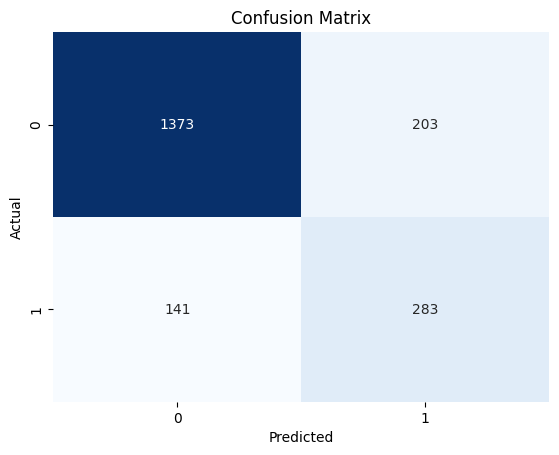

In [68]:
# Print confusion matrix
# Create a heatmap of the confusion matrix
sns.heatmap(confusion_mat_adjusted_final, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Logistic regression process

Identify the most important features

In [69]:
# Create a logistic regression model
model = LogisticRegression()

# Create the RFECV object
selector = RFECV(estimator=model, scoring='f1', cv=5)

# Perform feature selection
selector.fit(X_train, y_train)

RFECV(cv=5, estimator=LogisticRegression(), scoring='f1')

In [70]:
# Get the selected feature names
selected_features = X.columns[selector.support_]
selected_features

Index(['CustomerWithLoan', 'Geography_Rest_GR', 'Age_Band_35-45',
       'Age_Band_45-55', 'Age_Band_55-65', 'Age_Band_65+'],
      dtype='object')

Keep columns

In [71]:
selected_features = selected_features.union(['BalanceEuros','Geography_Thessaloniki','Age_Band_25-35'])
selected_features

Index(['Age_Band_25-35', 'Age_Band_35-45', 'Age_Band_45-55', 'Age_Band_55-65',
       'Age_Band_65+', 'BalanceEuros', 'CustomerWithLoan', 'Geography_Rest_GR',
       'Geography_Thessaloniki'],
      dtype='object')

In [72]:
# Convert X_train and X_test to pandas DataFrames
X_train_df = pd.DataFrame(X_train, columns=X.columns)
X_test_df = pd.DataFrame(X_test, columns=X.columns)

# Select the desired columns based on selected_features
X_train_selected = X_train_df[selected_features]
X_test_selected = X_test_df[selected_features]

Find optimal logistic model

In [73]:
model = LogisticRegression()

param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1.0, 10.0]
}

scorer = make_scorer(recall_score)
grid_search = GridSearchCV(model, param_grid, scoring=scorer, cv=10)

grid_search.fit(X_train_selected, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 1.0, 10.0], 'penalty': ['l1', 'l2']},
             scoring=make_scorer(recall_score))

Get the best parameters and the best score

In [74]:
best_paramsLOGREG = grid_search.best_params_
best_scoreLOGREG = grid_search.best_score_

best_modelLOGREG = LogisticRegression(**best_paramsLOGREG)
best_modelLOGREG.fit(X_train_selected, y_train)
y_predLOGREG = best_modelLOGREG.predict(X_test_selected)

# Compute evaluation metrics
reportLOGREG = classification_report(y_test, y_predLOGREG, target_names=['Active', 'Inactive'])
confusion_matLOGREG = confusion_matrix(y_test, y_predLOGREG)

Create a table with coefficients and odds ratios

In [75]:
# Create a DataFrame to store the model information
model_summary = pd.DataFrame()

# Add coefficient values
model_summary['Feature'] = selected_features
model_summary['Coefficient'] = best_modelLOGREG.coef_[0]

# Calculate odds ratios
odds_ratios = np.exp(best_modelLOGREG.coef_)
model_summary['Odds Ratio'] = odds_ratios[0]

# Add intercept value
intercept_odds_ratio = np.exp(best_modelLOGREG.intercept_[0])
model_summary.loc[len(model_summary)] = ['Intercept', best_modelLOGREG.intercept_[0], intercept_odds_ratio]

# Display the model summary
print("Model Summary:")
print(model_summary)


Model Summary:
                  Feature  Coefficient  Odds Ratio
0          Age_Band_25-35         0.06        1.06
1          Age_Band_35-45         1.02        2.77
2          Age_Band_45-55         2.53       12.54
3          Age_Band_55-65         2.64       14.08
4            Age_Band_65+         0.90        2.46
5            BalanceEuros         0.19        1.21
6        CustomerWithLoan        -0.94        0.39
7       Geography_Rest_GR         0.73        2.06
8  Geography_Thessaloniki         0.05        1.05
9               Intercept        -2.30        0.10


In [76]:
print(reportLOGREG)

              precision    recall  f1-score   support

      Active       0.85      0.95      0.90      1576
    Inactive       0.67      0.36      0.47       424

    accuracy                           0.83      2000
   macro avg       0.76      0.66      0.68      2000
weighted avg       0.81      0.83      0.81      2000



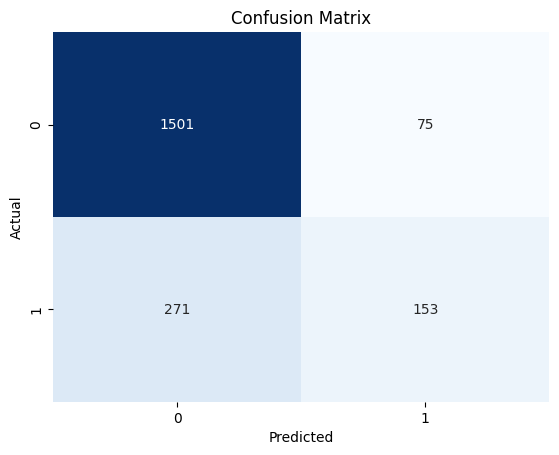

In [77]:
# Print confusion matrix
# Create a heatmap of the confusion matrix
sns.heatmap(confusion_matLOGREG, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()